In [1]:
from platform import python_version
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm

print(python_version()) # 3.12.7

3.12.7


In [2]:
## ---- ❤ Gemini|Deepseek: ❤  ---- 
# Este código lee los archivo parquet por batches y de forma incremental va creando los conjuntos de entrenamiento y testeo.
# Al final se guardan en un archivo parquet
def split_parquet(input_path, train_output="train3.parquet", test_output="test3.parquet", 
                  test_size=0.2, chunk_size=50000):
    # Delete existing files if any
    for f in [train_output, test_output]:
        if os.path.exists(f):
            os.remove(f)

    # Initialize input file
    input_file = pq.ParquetFile(input_path)
    total_rows = input_file.metadata.num_rows
    test_target = max(100, int(total_rows * test_size))  # Ensure minimum 100 test samples
    schema = input_file.schema.to_arrow_schema()
    rng = np.random.default_rng(42)

    # =================================================================
    # Phase 1: Select test indices using reservoir sampling
    # =================================================================
    test_indices = set()
    absolute_idx = 0
    
    # First pass: Fill test indices
    for batch in input_file.iter_batches():
        batch_size = batch.num_rows
        needed = test_target - len(test_indices)
        
        if needed <= 0:
            break
            
        # Generate candidate indices for this batch
        candidates = np.arange(absolute_idx, absolute_idx + batch_size)
        
        # Select up to 'needed' indices
        selected = rng.choice(candidates, size=min(needed, batch_size), replace=False)
        test_indices.update(selected.tolist())
        absolute_idx += batch_size

    # =================================================================
    # Phase 2: Write data to train/test files
    # =================================================================
    input_file = pq.ParquetFile(input_path)  # Reset reader
    
    with pq.ParquetWriter(train_output, schema) as writer_train, \
         pq.ParquetWriter(test_output, schema) as writer_test:
        
        absolute_idx = 0
        train_buffer = []
        test_buffer = []
        
        for batch in input_file.iter_batches():
            batch_df = batch.to_pandas(ignore_metadata=True)
            
            for idx_in_batch, _ in enumerate(batch_df.itertuples()):
                global_idx = absolute_idx + idx_in_batch
                
                if global_idx in test_indices:
                    test_buffer.append(batch_df.iloc[idx_in_batch:idx_in_batch+1])
                else:
                    train_buffer.append(batch_df.iloc[idx_in_batch:idx_in_batch+1])
                
                # Write buffers when full
                if len(train_buffer) >= chunk_size:
                    writer_train.write_table(pa.Table.from_pandas(
                        pd.concat(train_buffer), 
                        preserve_index=False
                    ))
                    train_buffer = []
                
                if len(test_buffer) >= chunk_size:
                    writer_test.write_table(pa.Table.from_pandas(
                        pd.concat(test_buffer),
                        preserve_index=False
                    ))
                    test_buffer = []
            
            absolute_idx += len(batch_df)
        
        # Flush remaining buffers
        if train_buffer:
            writer_train.write_table(pa.Table.from_pandas(
                pd.concat(train_buffer), 
                preserve_index=False
            ))
        if test_buffer:
            writer_test.write_table(pa.Table.from_pandas(
                pd.concat(test_buffer),
                preserve_index=False
            ))

    # =================================================================
    # Phase 3: Final validation and supplementation
    # =================================================================
    def validate_and_fix(file_path, min_rows=0):
        try:
            pf = pq.ParquetFile(file_path)
            if pf.metadata.num_rows >= min_rows:
                return True
        except:
            pass
        
        print(f"Rebuilding {file_path}")
        os.remove(file_path)
        pq.write_table(pa.Table.from_pandas(pd.DataFrame(), schema=schema), file_path)
        return False

    # Validate test file
    if not validate_and_fix(test_output, 100):
        print("Supplementing test set from train data")
        train_tbl = pq.read_table(train_output)
        test_tbl = pq.read_table(test_output)
        
        supplemental = train_tbl.slice(0, 100 - test_tbl.num_rows)
        new_test = pa.concat_tables([test_tbl, supplemental])
        new_train = train_tbl.slice(supplemental.num_rows)
        
        # Atomic write with deletion
        os.remove(train_output)
        os.remove(test_output)
        pq.write_table(new_train, train_output)
        pq.write_table(new_test, test_output)

    # Final validation
    for f in [train_output, test_output]:
        pf = pq.ParquetFile(f)
        print(f"Created {f}: {pf.metadata.num_rows} rows")

# Este código toma alreadedor de 45min en mi máquina

In [3]:
def evaluate_in_batches(model, test_path):
    """Safely evaluate model with empty test handling"""
    y_true = []
    y_pred = []
    
    try:
        test_file = pq.ParquetFile(test_path)
        if test_file.metadata.num_rows == 0:
            raise ValueError("Test set is empty!")
            
        for batch in test_file.iter_batches():
            batch_df = batch.to_pandas()
            X_batch = np.vstack(batch_df["features"].to_numpy())
            y_batch = batch_df["target"].to_numpy()
            
            y_true.extend(y_batch)
            y_pred.extend(model.predict(X_batch))
            
        if not y_true:
            raise ValueError("No samples in test set!")
            
        return (
            mean_squared_error(y_true, y_pred, squared=False),
            mean_absolute_error(y_true, y_pred)
        )
    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        return (float('nan'), float('nan'))  # Return NaNs for plotting

In [4]:
# Como no es posible cargar todo el archivo parquet en la memoria, se hace un entrenamiento incremental (por Batches)
def train_incremental(train_path, test_path, train_fractions=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]):
    model = SGDRegressor(penalty='l2', alpha=0.0001, max_iter=1000)
    train_file = pq.ParquetFile(train_path)
    total_train_rows = train_file.metadata.num_rows
    rmse_scores = []
    mae_scores = []
    
    for fraction in train_fractions:
        target_rows = int(total_train_rows * fraction)
        current_rows = 0
        
        model = SGDRegressor(penalty='l2', alpha=0.0001, max_iter=1000)
        
        for batch in train_file.iter_batches():
            if current_rows >= target_rows:
                break
                
            batch_df = batch.to_pandas()
            X_batch = np.vstack(batch_df["features"].to_numpy())
            y_batch = batch_df["target"].to_numpy()
            if current_rows + len(y_batch) > target_rows:
                keep = target_rows - current_rows
                X_batch = X_batch[:keep]
                y_batch = y_batch[:keep]
            
            model.partial_fit(X_batch, y_batch)
            current_rows += len(y_batch)
            print(f"Trained: {current_rows}/{target_rows} | RAM: {len(y_batch)*1966*4/1e6:.1f}MB")
        
        if not validate_parquet(test_path):
            raise RuntimeError("Test file corrupted!")
        
        # Evaluate
        rmse, mae = evaluate_in_batches(model, test_path)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        print(f"Fraction: {fraction:.0%} | RMSE: {rmse:.3f}, MAE: {mae:.3f}")
    
    return rmse_scores, mae_scores

In [9]:
# Clean existing files
for f in ["train3.parquet", "test3.parquet"]:
    if os.path.exists(f):
        os.remove(f)

split_parquet(
    os.getcwd() + "/finaldataset.parquet",
    test_size=0.2,
    chunk_size=50000  # Adjust based on RAM (50k ≈ 392MB)
)

Created train3.parquet: 3277666 rows
Created test3.parquet: 819416 rows


In [10]:
def validate_parquet(path):
    try:
        pf = pq.ParquetFile(path)
        print(f"{path}: {pf.metadata.num_rows} rows (valid)")
        return True
    except Exception as e:
        print(f"{path}: INVALID ({str(e)})")
        return False

assert validate_parquet("train3.parquet"), "Train file invalid!"
assert validate_parquet("test3.parquet"), "Test file invalid!"

train3.parquet: 3277666 rows (valid)
test3.parquet: 819416 rows (valid)


Train: 3277666 rows | Test: 819416 rows
Trained: 65536/327766 | RAM: 515.4MB
Trained: 131072/327766 | RAM: 515.4MB
Trained: 196608/327766 | RAM: 515.4MB
Trained: 262144/327766 | RAM: 515.4MB
Trained: 327680/327766 | RAM: 515.4MB
Trained: 327766/327766 | RAM: 0.7MB
test3.parquet: 819416 rows (valid)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 10% | RMSE: 1.301, MAE: 1.075
Trained: 65536/655533 | RAM: 515.4MB
Trained: 131072/655533 | RAM: 515.4MB
Trained: 196608/655533 | RAM: 515.4MB
Trained: 262144/655533 | RAM: 515.4MB
Trained: 327680/655533 | RAM: 515.4MB
Trained: 393216/655533 | RAM: 515.4MB
Trained: 458752/655533 | RAM: 515.4MB
Trained: 524288/655533 | RAM: 515.4MB
Trained: 589824/655533 | RAM: 515.4MB
Trained: 655360/655533 | RAM: 515.4MB
Trained: 655533/655533 | RAM: 1.4MB
test3.parquet: 819416 rows (valid)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 20% | RMSE: 1.296, MAE: 1.053
Trained: 65536/1311066 | RAM: 515.4MB
Trained: 131072/1311066 | RAM: 515.4MB
Trained: 196608/1311066 | RAM: 515.4MB
Trained: 262144/1311066 | RAM: 515.4MB
Trained: 327680/1311066 | RAM: 515.4MB
Trained: 393216/1311066 | RAM: 515.4MB
Trained: 458752/1311066 | RAM: 515.4MB
Trained: 524288/1311066 | RAM: 515.4MB
Trained: 589824/1311066 | RAM: 515.4MB
Trained: 655360/1311066 | RAM: 515.4MB
Trained: 720896/1311066 | RAM: 515.4MB
Trained: 786432/1311066 | RAM: 515.4MB
Trained: 851968/1311066 | RAM: 515.4MB
Trained: 917504/1311066 | RAM: 515.4MB
Trained: 983040/1311066 | RAM: 515.4MB
Trained: 1048576/1311066 | RAM: 515.4MB
Trained: 1114112/1311066 | RAM: 515.4MB
Trained: 1179648/1311066 | RAM: 515.4MB
Trained: 1245184/1311066 | RAM: 515.4MB
Trained: 1310720/1311066 | RAM: 515.4MB
Trained: 1311066/1311066 | RAM: 2.7MB
test3.parquet: 819416 rows (valid)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 40% | RMSE: 1.295, MAE: 1.062
Trained: 65536/1966599 | RAM: 515.4MB
Trained: 131072/1966599 | RAM: 515.4MB
Trained: 196608/1966599 | RAM: 515.4MB
Trained: 262144/1966599 | RAM: 515.4MB
Trained: 327680/1966599 | RAM: 515.4MB
Trained: 393216/1966599 | RAM: 515.4MB
Trained: 458752/1966599 | RAM: 515.4MB
Trained: 524288/1966599 | RAM: 515.4MB
Trained: 589824/1966599 | RAM: 515.4MB
Trained: 655360/1966599 | RAM: 515.4MB
Trained: 720896/1966599 | RAM: 515.4MB
Trained: 786432/1966599 | RAM: 515.4MB
Trained: 851968/1966599 | RAM: 515.4MB
Trained: 917504/1966599 | RAM: 515.4MB
Trained: 983040/1966599 | RAM: 515.4MB
Trained: 1048576/1966599 | RAM: 515.4MB
Trained: 1114112/1966599 | RAM: 515.4MB
Trained: 1179648/1966599 | RAM: 515.4MB
Trained: 1245184/1966599 | RAM: 515.4MB
Trained: 1310720/1966599 | RAM: 515.4MB
Trained: 1376256/1966599 | RAM: 515.4MB
Trained: 1441792/1966599 | RAM: 515.4MB
Trained: 1507328/1966599 | RAM: 515.4MB
Trained: 1572864/1966599 | RAM: 515.4MB
Trained: 1638400

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 60% | RMSE: 1.292, MAE: 1.054
Trained: 65536/2622132 | RAM: 515.4MB
Trained: 131072/2622132 | RAM: 515.4MB
Trained: 196608/2622132 | RAM: 515.4MB
Trained: 262144/2622132 | RAM: 515.4MB
Trained: 327680/2622132 | RAM: 515.4MB
Trained: 393216/2622132 | RAM: 515.4MB
Trained: 458752/2622132 | RAM: 515.4MB
Trained: 524288/2622132 | RAM: 515.4MB
Trained: 589824/2622132 | RAM: 515.4MB
Trained: 655360/2622132 | RAM: 515.4MB
Trained: 720896/2622132 | RAM: 515.4MB
Trained: 786432/2622132 | RAM: 515.4MB
Trained: 851968/2622132 | RAM: 515.4MB
Trained: 917504/2622132 | RAM: 515.4MB
Trained: 983040/2622132 | RAM: 515.4MB
Trained: 1048576/2622132 | RAM: 515.4MB
Trained: 1114112/2622132 | RAM: 515.4MB
Trained: 1179648/2622132 | RAM: 515.4MB
Trained: 1245184/2622132 | RAM: 515.4MB
Trained: 1310720/2622132 | RAM: 515.4MB
Trained: 1376256/2622132 | RAM: 515.4MB
Trained: 1441792/2622132 | RAM: 515.4MB
Trained: 1507328/2622132 | RAM: 515.4MB
Trained: 1572864/2622132 | RAM: 515.4MB
Trained: 1638400

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 80% | RMSE: 1.291, MAE: 1.053
Trained: 65536/3277666 | RAM: 515.4MB
Trained: 131072/3277666 | RAM: 515.4MB
Trained: 196608/3277666 | RAM: 515.4MB
Trained: 262144/3277666 | RAM: 515.4MB
Trained: 327680/3277666 | RAM: 515.4MB
Trained: 393216/3277666 | RAM: 515.4MB
Trained: 458752/3277666 | RAM: 515.4MB
Trained: 524288/3277666 | RAM: 515.4MB
Trained: 589824/3277666 | RAM: 515.4MB
Trained: 655360/3277666 | RAM: 515.4MB
Trained: 720896/3277666 | RAM: 515.4MB
Trained: 786432/3277666 | RAM: 515.4MB
Trained: 851968/3277666 | RAM: 515.4MB
Trained: 917504/3277666 | RAM: 515.4MB
Trained: 983040/3277666 | RAM: 515.4MB
Trained: 1048576/3277666 | RAM: 515.4MB
Trained: 1114112/3277666 | RAM: 515.4MB
Trained: 1179648/3277666 | RAM: 515.4MB
Trained: 1245184/3277666 | RAM: 515.4MB
Trained: 1310720/3277666 | RAM: 515.4MB
Trained: 1376256/3277666 | RAM: 515.4MB
Trained: 1441792/3277666 | RAM: 515.4MB
Trained: 1507328/3277666 | RAM: 515.4MB
Trained: 1572864/3277666 | RAM: 515.4MB
Trained: 1638400

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 100% | RMSE: 1.290, MAE: 1.045


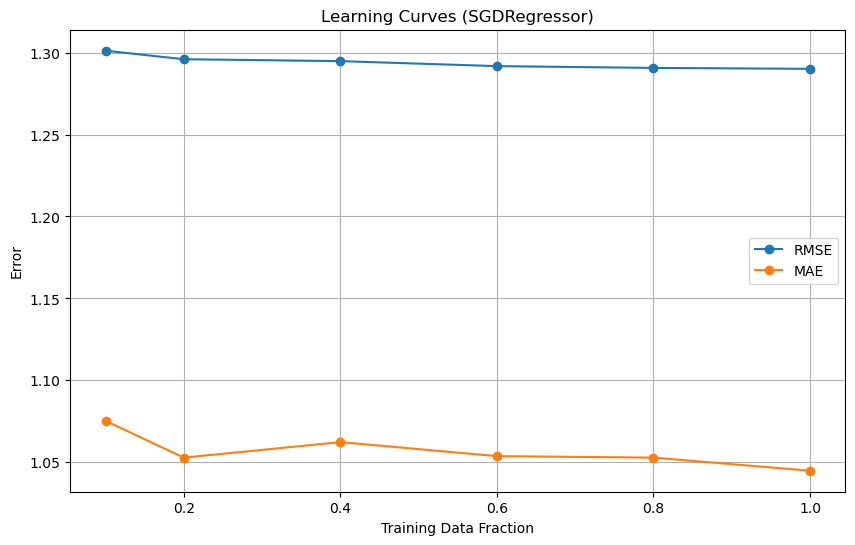

In [11]:

# Verify splits
train_stats = pq.ParquetFile("train3.parquet").metadata
test_stats = pq.ParquetFile("test3.parquet").metadata
print(f"Train: {train_stats.num_rows} rows | Test: {test_stats.num_rows} rows")

# Generate learning curves
train_fractions = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
rmse, mae = train_incremental("train3.parquet", "test3.parquet",train_fractions)

# Plot results]
plt.figure(figsize=(10, 6))
plt.plot(train_fractions, rmse, 'o-', label='RMSE')
plt.plot(train_fractions, mae, 'o-', label='MAE')
plt.xlabel('Training Data Fraction')
plt.ylabel('Error')
plt.title('Learning Curves (SGDRegressor)')
plt.legend()
plt.grid()
plt.savefig('learning_curves2.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
def train_incremental_model2(train_path, test_path, train_fractions=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]):
    model = SGDRegressor(loss='huber', penalty='elasticnet', alpha=0.001,learning_rate='adaptive',eta0=0.01, max_iter=1000)
    train_file = pq.ParquetFile(train_path)
    total_train_rows = train_file.metadata.num_rows
    rmse_scores = []
    mae_scores = []
    
    for fraction in train_fractions:
        target_rows = int(total_train_rows * fraction)
        current_rows = 0
        
        # Reset model for each fraction
        model = SGDRegressor(loss='huber',  # Robust to outliers
        penalty='elasticnet',  # Mix of L1/L2 regularization
        alpha=0.001,   # Lower regularization
        learning_rate='adaptive',
        eta0=0.01,
        max_iter=1000)
        
        # Full pass through data with early stopping
        for batch in train_file.iter_batches():
            if current_rows >= target_rows:
                break
                
            batch_df = batch.to_pandas()
            X_batch = np.vstack(batch_df["features"].to_numpy())
            y_batch = batch_df["target"].to_numpy()
            
            # Trim excess rows
            if current_rows + len(y_batch) > target_rows:
                keep = target_rows - current_rows
                X_batch = X_batch[:keep]
                y_batch = y_batch[:keep]
            
            model.partial_fit(X_batch, y_batch)
            current_rows += len(y_batch)
            print(f"Trained: {current_rows}/{target_rows} | RAM: {len(y_batch)*1966*4/1e6:.1f}MB")
        
        # Verify test file before evaluation
        if not validate_parquet(test_path):
            raise RuntimeError("Test file corrupted!")
        
        # Evaluate
        rmse, mae = evaluate_in_batches(model, test_path)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        print(f"Fraction: {fraction:.0%} | RMSE: {rmse:.3f}, MAE: {mae:.3f}")
    
    return rmse_scores, mae_scores

Train: 3277666 rows | Test: 819416 rows
Trained: 65536/327766 | RAM: 515.4MB
Trained: 131072/327766 | RAM: 515.4MB
Trained: 196608/327766 | RAM: 515.4MB
Trained: 262144/327766 | RAM: 515.4MB
Trained: 327680/327766 | RAM: 515.4MB
Trained: 327766/327766 | RAM: 0.7MB
test3.parquet: 819416 rows (valid)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 10% | RMSE: 1.346, MAE: 1.024
Trained: 65536/655533 | RAM: 515.4MB
Trained: 131072/655533 | RAM: 515.4MB
Trained: 196608/655533 | RAM: 515.4MB
Trained: 262144/655533 | RAM: 515.4MB
Trained: 327680/655533 | RAM: 515.4MB
Trained: 393216/655533 | RAM: 515.4MB
Trained: 458752/655533 | RAM: 515.4MB
Trained: 524288/655533 | RAM: 515.4MB
Trained: 589824/655533 | RAM: 515.4MB
Trained: 655360/655533 | RAM: 515.4MB
Trained: 655533/655533 | RAM: 1.4MB
test3.parquet: 819416 rows (valid)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 20% | RMSE: 1.342, MAE: 1.021
Trained: 65536/1311066 | RAM: 515.4MB
Trained: 131072/1311066 | RAM: 515.4MB
Trained: 196608/1311066 | RAM: 515.4MB
Trained: 262144/1311066 | RAM: 515.4MB
Trained: 327680/1311066 | RAM: 515.4MB
Trained: 393216/1311066 | RAM: 515.4MB
Trained: 458752/1311066 | RAM: 515.4MB
Trained: 524288/1311066 | RAM: 515.4MB
Trained: 589824/1311066 | RAM: 515.4MB
Trained: 655360/1311066 | RAM: 515.4MB
Trained: 720896/1311066 | RAM: 515.4MB
Trained: 786432/1311066 | RAM: 515.4MB
Trained: 851968/1311066 | RAM: 515.4MB
Trained: 917504/1311066 | RAM: 515.4MB
Trained: 983040/1311066 | RAM: 515.4MB
Trained: 1048576/1311066 | RAM: 515.4MB
Trained: 1114112/1311066 | RAM: 515.4MB
Trained: 1179648/1311066 | RAM: 515.4MB
Trained: 1245184/1311066 | RAM: 515.4MB
Trained: 1310720/1311066 | RAM: 515.4MB
Trained: 1311066/1311066 | RAM: 2.7MB
test3.parquet: 819416 rows (valid)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 40% | RMSE: 1.348, MAE: 1.027
Trained: 65536/1966599 | RAM: 515.4MB
Trained: 131072/1966599 | RAM: 515.4MB
Trained: 196608/1966599 | RAM: 515.4MB
Trained: 262144/1966599 | RAM: 515.4MB
Trained: 327680/1966599 | RAM: 515.4MB
Trained: 393216/1966599 | RAM: 515.4MB
Trained: 458752/1966599 | RAM: 515.4MB
Trained: 524288/1966599 | RAM: 515.4MB
Trained: 589824/1966599 | RAM: 515.4MB
Trained: 655360/1966599 | RAM: 515.4MB
Trained: 720896/1966599 | RAM: 515.4MB
Trained: 786432/1966599 | RAM: 515.4MB
Trained: 851968/1966599 | RAM: 515.4MB
Trained: 917504/1966599 | RAM: 515.4MB
Trained: 983040/1966599 | RAM: 515.4MB
Trained: 1048576/1966599 | RAM: 515.4MB
Trained: 1114112/1966599 | RAM: 515.4MB
Trained: 1179648/1966599 | RAM: 515.4MB
Trained: 1245184/1966599 | RAM: 515.4MB
Trained: 1310720/1966599 | RAM: 515.4MB
Trained: 1376256/1966599 | RAM: 515.4MB
Trained: 1441792/1966599 | RAM: 515.4MB
Trained: 1507328/1966599 | RAM: 515.4MB
Trained: 1572864/1966599 | RAM: 515.4MB
Trained: 1638400

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 60% | RMSE: 1.340, MAE: 1.020
Trained: 65536/2622132 | RAM: 515.4MB
Trained: 131072/2622132 | RAM: 515.4MB
Trained: 196608/2622132 | RAM: 515.4MB
Trained: 262144/2622132 | RAM: 515.4MB
Trained: 327680/2622132 | RAM: 515.4MB
Trained: 393216/2622132 | RAM: 515.4MB
Trained: 458752/2622132 | RAM: 515.4MB
Trained: 524288/2622132 | RAM: 515.4MB
Trained: 589824/2622132 | RAM: 515.4MB
Trained: 655360/2622132 | RAM: 515.4MB
Trained: 720896/2622132 | RAM: 515.4MB
Trained: 786432/2622132 | RAM: 515.4MB
Trained: 851968/2622132 | RAM: 515.4MB
Trained: 917504/2622132 | RAM: 515.4MB
Trained: 983040/2622132 | RAM: 515.4MB
Trained: 1048576/2622132 | RAM: 515.4MB
Trained: 1114112/2622132 | RAM: 515.4MB
Trained: 1179648/2622132 | RAM: 515.4MB
Trained: 1245184/2622132 | RAM: 515.4MB
Trained: 1310720/2622132 | RAM: 515.4MB
Trained: 1376256/2622132 | RAM: 515.4MB
Trained: 1441792/2622132 | RAM: 515.4MB
Trained: 1507328/2622132 | RAM: 515.4MB
Trained: 1572864/2622132 | RAM: 515.4MB
Trained: 1638400

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 80% | RMSE: 1.340, MAE: 1.021
Trained: 65536/3277666 | RAM: 515.4MB
Trained: 131072/3277666 | RAM: 515.4MB
Trained: 196608/3277666 | RAM: 515.4MB
Trained: 262144/3277666 | RAM: 515.4MB
Trained: 327680/3277666 | RAM: 515.4MB
Trained: 393216/3277666 | RAM: 515.4MB
Trained: 458752/3277666 | RAM: 515.4MB
Trained: 524288/3277666 | RAM: 515.4MB
Trained: 589824/3277666 | RAM: 515.4MB
Trained: 655360/3277666 | RAM: 515.4MB
Trained: 720896/3277666 | RAM: 515.4MB
Trained: 786432/3277666 | RAM: 515.4MB
Trained: 851968/3277666 | RAM: 515.4MB
Trained: 917504/3277666 | RAM: 515.4MB
Trained: 983040/3277666 | RAM: 515.4MB
Trained: 1048576/3277666 | RAM: 515.4MB
Trained: 1114112/3277666 | RAM: 515.4MB
Trained: 1179648/3277666 | RAM: 515.4MB
Trained: 1245184/3277666 | RAM: 515.4MB
Trained: 1310720/3277666 | RAM: 515.4MB
Trained: 1376256/3277666 | RAM: 515.4MB
Trained: 1441792/3277666 | RAM: 515.4MB
Trained: 1507328/3277666 | RAM: 515.4MB
Trained: 1572864/3277666 | RAM: 515.4MB
Trained: 1638400

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fraction: 100% | RMSE: 1.339, MAE: 1.020


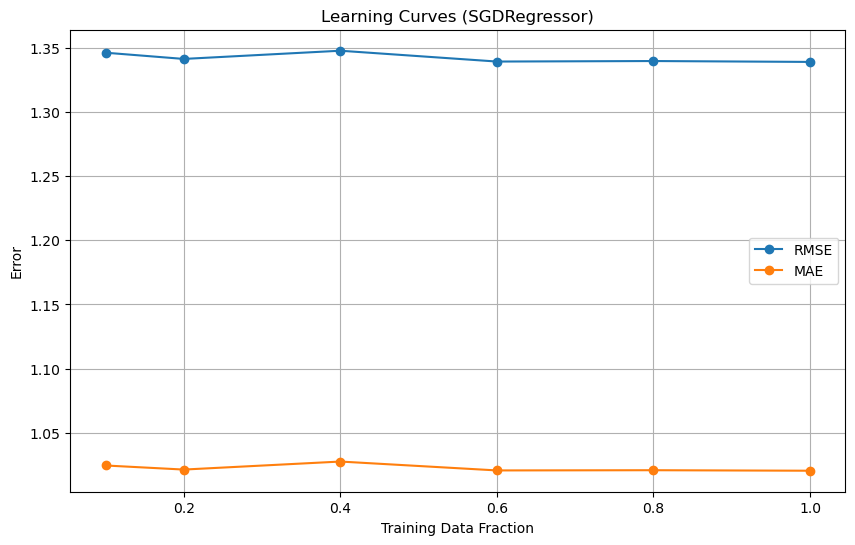

In [19]:

# Verify splits
train_stats = pq.ParquetFile("train3.parquet").metadata
test_stats = pq.ParquetFile("test3.parquet").metadata
print(f"Train: {train_stats.num_rows} rows | Test: {test_stats.num_rows} rows")

# Generate learning curves
train_fractions = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
rmse, mae = train_incremental_model2("train3.parquet", "test3.parquet",train_fractions)

# Plot results]
plt.figure(figsize=(10, 6))
plt.plot(train_fractions, rmse, 'o-', label='RMSE')
plt.plot(train_fractions, mae, 'o-', label='MAE')
plt.xlabel('Training Data Fraction')
plt.ylabel('Error')
plt.title('Learning Curves (SGDRegressor)')
plt.legend()
plt.grid()
plt.savefig('learning_curves_model2.png', dpi=300, bbox_inches='tight')
plt.show()